# Price Determinants in the Seattle AirBnB Market

This notebook analyses price determinants in the Seattle AirBnB market using a CRISP-DM process. For the README, data sources, and other information related to this project, please see [the corresponding github repo](https://github.com/epistemetrica/udacity-blog-post-project). 

## Business Understanding

How are prices determined for AirBnB listings in Seattle? In the most basic sense, the host sets the price for the listing based on their best guess of what renters are willing to pay for it. Intuitively, we imagine the host considers factors such as the location of the rental and the features that it offers, and thus listings in "nice" neighborhoods and with premium amenities like free parking or hot tubs will be listed at higher prices. 

This project has two parts. First, I test three questions against the available data:
- Which locations do renters prefer?
- For which features and amenities are renters willing to pay a premium? 
- Do renters place any value on the reputation of the host?

Second, I develop a pricing model to help future hosts decide where to set prices (and to help renters judge whether a fair price is being asked). 

## Data Understanding

My data come from AirBnB listings, scraped on July 18th, 2023 by Inside AirBnB (see the above-linked github page for more detailed info on the raw data). Importantly, the prices in this dataset are _advertised_ prices, not the prices at which the listings actually sell. This is a serious limitation when it comes to analyzing the business questions above. However, this is a data science portfolio project, not a formal academic analysis or industry report, so I will make the possibly-unrealistic assumption that listed prices are a decent proxy for sales prices and get on with it. 

That limitation aside, the dataset from Inside AirBnB contains a great deal of information about each listing including the listing's location, features (guest capacity, number of bedrooms and bathrooms, etc), and amenities (air conditioning, parking, wifi, etc). It also includes information about the host (whether or not they are a superhost, how many listings each host manages, etc.). 

I use two main files from Inside AirBnB: a csv file containing the above data associated with each listing, and a geojson file containing neighborhood geometries for Seattle, which coorespond to the neighbourhoods listed in the csv.

Armed with these data, we can address the above questions. 


## Data Preparation Part 1: The Basics

The data come from Inside AirBnB in csv and geojson files that are quite tidy, all things considered. However, many columns contain data in impractical data types (such as price or date info cast as strings), and data such as listing amenities are contained in long lists of strings within single cells. So, lets get to it!

First, let's install all the libraries we will use throughout this notebook and get that out of the way:

In [1]:
#install libraries
import numpy as np
import pandas as pd
import scipy 
import matplotlib.pyplot as plt
import seaborn as sns
import folium 
import geopandas as gpd
from geopy import distance
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm

#remove limit on number of displayed columns
pd.set_option('display.max_columns', None)

### Recasting to the appropriate data type

Next, let's load the data and recast the various strings into the appropriate data types.

In [2]:
#load data
listings_df = pd.read_csv('airbnb_data_seattle/listings.csv')

In [3]:
#recast price data from string to float

def price_str_to_float(df, *cols):
    ''' 
    INPUT:
        df - a pandas dataframe
        cols - any price columns you want to recast from string to float - expected string format is $9,999.99
    NOTE: this change is made IN PLACE
    '''
    for col in cols:
        df[col] = df[col].str.replace('$','').str.replace(',','').astype('float')

price_str_to_float(listings_df, 'price')

In [4]:
#recast date data from string to pandas datetime

def date_str_to_datetime(df, *cols):
    ''' 
    INPUT:
       df - a pandas dataframe
       cols - any date columns you want to recast from string to float
    NOTE: this change is made IN PLACE
    '''
    for col in cols:
        df[col] = pd.to_datetime(df[col])

date_str_to_datetime(listings_df, 'host_since', 'first_review', 'last_review')

In [5]:
#recast percents and rates from string to float

def percent_str_to_float(df, *cols):
    '''
    INPUT: 
        df - a pandas dataframe
        cols - any percent or rate columns you want to recast from string to float (e.g. '20%' will become .20)
    NOTE: this change is made IN PLACE
    '''
    for col in cols:
        df[col] = df[col].str.replace('%','').astype('float')
        df[col] = df[col]/100

percent_str_to_float(listings_df, 'host_response_rate', 'host_acceptance_rate')

In [6]:
#recast columns with 't' and 'f' strings to boolean 

def tf_to_bool(df, *cols):
    '''
    INPUT:
        df - a pandas dataframe
        cols - any columns with 't' and 'f' strings you want to recast to boolean dtype
    NOTE: this change is made IN PLACE
    '''
    for col in cols:
        df[col] = df[col].map({'t': True,'f': False, np.nan: False})

tf_to_bool(listings_df, 'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'instant_bookable', 'license')

### Converting text descriptions into quantitative variables

The data on bathrooms for each listing is messy&mdash;the 'bathrooms' column is empty, and the 'bathrooms_text' column includes various entries such as "1 shared bath" or "Private half-bath." Since there are only 28 unique strings in the 'bathrooms_text' column, I chose a brute force mapping approach rather than building a function to interpret the various responses. 

In [7]:
#obtain unique entries in the 'bathroom_text' col
listings_df['bathrooms_text'].unique();

#map values from 'bathrooms_text' into 'bathrooms' as numerical values
listings_df['bathrooms'] = listings_df['bathrooms_text'].map({'2 baths': 2, '1 bath': 1, '1 shared bath': 1, '1 private bath': 1,
       '2.5 baths': 2.5, '3.5 baths': 3.5, '3 baths': 3, '4 baths': 4, '1.5 baths': 1.5,
       '2 shared baths': 2, '4.5 baths': 4.5, 'Half-bath': 0.5, '0 shared baths': 0,
       '3 shared baths': 3, '4 shared baths': 4, '3.5 shared baths': 3.5,
       '1.5 shared baths': 1.5, 'Private half-bath': 0.5, '6 baths': 6,
       '16 shared baths': 16, '0 baths': 0, '6.5 baths': 6.5, '5 baths': 5,
       '2.5 shared baths': 2.5, 'Shared half-bath': 0.5, '7 baths': 7, '5.5 baths': 5.5})

### Converting category strings to Pandas Category dtype

In [8]:
#recast from strings to categories
listings_df[['host_response_time', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'property_type', 'room_type']] = listings_df[['host_response_time', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'property_type', 'room_type']].astype('category')

#apply order to host response time category
listings_df.host_response_time = listings_df.host_response_time.cat.set_categories(['within an hour', 'within a few hours', 'within a day', 'a few days or more'], ordered= True)

### Spurious data and empty columns

Some listings seem a bit spurious. For instance, a single host represents all the listings above $5,000 (4 of which are at the same location and listed at $10,000.00), and all their listings have extravagant prices for normal-looking listings. I drop this host, as well as listings with a price of $0 and any columns with completely missing data.

In [9]:
#drop spurious host id
listings_df = listings_df.drop(listings_df[listings_df.host_id == 241568755].index)

#drop $0 listings
listings_df = listings_df.drop(listings_df[listings_df.price == 0].index)

#drop columns with missing data
listings_df.dropna(axis=1, how='all', inplace=True);

### Amenities

The amenities offered by each listing are encoded as a long string of all the diffrent amenities in the form "["feature 1", "feature 2", ...]". We will save the creation of dummy variables for later, but for now let's turn that into a proper python list. 

In [10]:
#clean up amenities column into an actual python list 
listings_df.amenities = listings_df.amenities.apply(eval)

### Natural log of prices

So that we can interpret the effects of each variable on the % change in prices (rather than the absolute number of dollars), I will go ahead and take the natural log of prices. 

In [11]:
#log prices
listings_df['ln_price'] = np.log(listings_df.price)

### Distance to City Center

A classic metric in the economic evaluation of property values is the property's distance from the city center. Let's look first at the geometric distances between each listing and the city center. Since our geographic area of interest is small, the cartesian distance between coordinates would be accurate enough. However, I'm a huge nerd so I'm going to use the geodesic distance based on the WGS-84 ellipoid.

In [12]:
#seattle city center, obtained from google
city_center = (47.6050,-122.3344) 

#GeoPy distance function expects a lat/long tuple, so:
listings_df['coordinates'] = tuple(zip(listings_df.latitude, listings_df.longitude))

#compute distance for each listing
listings_df['distance_from_cc'] = listings_df.apply(lambda row: distance.distance(row.coordinates, city_center).miles, axis=1)

### Drop unused columns and rename as appropriate

The dataframe includes a number of columns that are not useful to this analysis. Either they are repetitive in one way or another, such as the 'bathrooms' and 'bathrooms_text' columns mentioned above, or they are unrelated to the question of price determinants (e.g., since we are using listed prices as a proxy for sales prices, we are not concerned with whether the listing is available). 

In [13]:
#drop unused columns
listings_df = listings_df.drop(columns=['name', 'description', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'picture_url', 'host_url',
                                        'host_name', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url',
                                        'host_listings_count', 'host_total_listings_count', 'host_verifications', 'neighbourhood',
                                        'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights',
                                        'minimum_maximum_nights', 'maximum_maximum_nights', 'has_availability', 'availability_30',
                                        'availability_60', 'availability_90', 'availability_365', 'calendar_last_scraped', 
                                        'number_of_reviews_ltm', 'number_of_reviews_l30d', 'last_review', 'license', 
                                        'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms',
                                        'calculated_host_listings_count_shared_rooms', 'bathrooms_text', 'host_neighbourhood', 'latitude',
                                        'longitude', 'neighborhood_overview'])

In [14]:
#rename 
listings_df['neighbourhood'] = listings_df['neighbourhood_cleansed']
listings_df['neighbourhood_group'] = listings_df['neighbourhood_group_cleansed']
listings_df['min_nights'] = listings_df['minimum_nights_avg_ntm']
listings_df['max_nights'] = listings_df['maximum_nights_avg_ntm']
listings_df['host_listings_count'] = listings_df['calculated_host_listings_count']

#drop
listings_df = listings_df.drop(columns=['neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calculated_host_listings_count'])

### Reorder columns

Finally, I re-order the columns for the sake of sanity

In [15]:
#reorder columns (as copy to avoid view/copy confusion)
listings_df = listings_df[['id', 'price', 'ln_price', 'coordinates', 'distance_from_cc', 
                           'neighbourhood', 'neighbourhood_group', 'property_type', 'room_type', 'accommodates', 'bathrooms', 
                           'bedrooms', 'beds', 'amenities', 'number_of_reviews', 'first_review', 'review_scores_rating',
                           'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication',
                           'review_scores_location', 'review_scores_value', 'reviews_per_month', 'min_nights', 'max_nights',
                           'instant_bookable', 'host_id', 'host_since', 'host_response_time', 'host_response_rate', 'host_acceptance_rate',
                           'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'host_listings_count']].copy()

## Data Preparation Part 2: Dummy Variables

Now that the basic data set is all clean and tidy, it's time to create dummy variables. The number of possible dummy variables is quite large, so I will only create the variables that will be useful later on. 

In the modeling section, I run a model from a popular paper by Gibbs and collaborators, who include whether a listing is an independent property or part of a multi-unit building. The authors do not specify exactly how they determined this, and my dataset contains 52 unique descriptions of property type such as "Entire rental unit", "Private room in bed and breakfast", "Tiny home", etc. So I will play fast-and-loose here and categorize property types as "independent" based on my best guess from the property type description.

In [16]:
#define independent property types
independent_types = ['Entire home', 'Entire townhouse', 'Entire guesthouse', 'Entire Cottage', 'Entire bungalow', 'Entire vacation home',
                     'Tiny home', 'Entire cabin', 'Entire villa', 'Boat', 'Houseboat', 'Camper/RV', 'Entire place', 'Bus', 'Tent', 
                     'Casa particular', 'Farm stay']

listings_df['independant_property'] = listings_df.apply(lambda row: True if row.property_type in independent_types else False, axis=1)

As mentioned above, the amenities data is contained in long lists in each cell of the column, so for each variable (free parking, wifi, etc) I isolate the strings that define the variable then create dummies based on whether or not the listing includes one of the relevant strings. 

In [17]:
#define function to find any member of a string in another string
def string_list_search(strings_to_find, strings_to_search):
    ''' 
    Input:
        strings_to_find - a list of strings you want to find
        strings_to_search - a list of strings where you may find the strings you want to find
    Output:
        boolean returning true if any of the strings in strings_to_find occur in strings_to_search
    '''
    if any(string in strings_to_find for string in strings_to_search):
        return True
    return False

In [18]:
#dummy variable creation function from the course lessons
def create_dummy_df(df, *cat_cols, dummy_na):
    ''' 
    Input: 
    df - a pandas dataframe with categorical variables
    cat_cols - strings corresponding to the categorical column names
    dummy_na - whether or not you want dummy_na category for your variable, default = True

    Output:
    df - a new dataframe with the following characteristics:
        - contains all the columns not specified under cat_cols
        - removes all the original columsn specified under cat_cols
        - uses a prefix for the new columns corresponding to the original column name
    
    NOTE: this changes is made IN PLACE
    '''
    for col in cat_cols:
        df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', dummy_na=dummy_na)], axis=1)
    return df 

In [19]:
#get list of unique amenities strings
unique_amenities = [str(i) for i in list(listings_df.amenities.explode().unique())]

In [20]:
#get gym list
gym_list = list(filter(lambda x: 'gym'.lower() in x.lower(), unique_amenities))

#create gym dummy variable
listings_df['gym'] = listings_df.apply(lambda row: string_list_search(gym_list, row.amenities), axis= 1)

In [21]:
#get list of amenities including pool (trying to avoid including Whirlpool appliances, etc.)
pool_list = list(filter(lambda x: ' pool'.lower() in x.lower(), unique_amenities))
Pool_list = list(filter(lambda x: 'Pool' in x, unique_amenities))
pool_list = Pool_list + pool_list
pool_list.remove('WhitePool refrigerator')

#create dummy variable for pool 
listings_df['pool'] = listings_df.apply(lambda row: string_list_search(pool_list, row.amenities), axis= 1)


In [22]:
#get parking list
parking_amenities = list(filter(lambda x: 'parking'.lower() in x.lower(), unique_amenities))

#inspect strings that mention parking
parking_amenities;

#create free parking strings list
free_parking_strings = ['Free driveway parking on premises – 2 spaces', 'Free street parking', 'Free parking on premises',
                        'Free driveway parking on premises – 1 space', 'Free driveway parking on premises', 'Free parking on premises – 1 space',
                        'Free parking garage on premises – 1 space', 'Free driveway parking on premises – 3 spaces', 'Free parking on premises – 2 spaces',
                        'Free driveway parking on premises – 11 spaces', 'Free parking on premises – 3 spaces', 'Free parking garage on premises – 2 spaces',
                        'Free driveway parking on premises – 4 spaces', 'Free parking garage on premises', 'Free parking garage on premises – 11 spaces', 
                        'Free parking on premises – 4 spaces', 'Free parking garage on premises – 4 spaces', 'Free driveway parking on premises – 7 spaces']

#create free parking dummy variable
listings_df['free_parking'] = listings_df.apply(lambda row: string_list_search(free_parking_strings, row.amenities), axis= 1)

In [23]:
#get beachfront/waterfront list
beachfront_list = list(filter(lambda x: 'beach'.lower() in x.lower(), unique_amenities))
waterfront_list = list(filter(lambda x: 'waterfront'.lower() in x.lower(), unique_amenities))
waterfront_list = waterfront_list + beachfront_list

#finalize list
waterfront_list = ['Waterfront', 'Public or shared beach access – Beachfront', 'Public or shared beach access', 
                   'Beach access – Beachfront','Beach access', 'Beach view', 'Private beach access', 'Private beach access – Beachfront']
#create waterfront dummy variable
listings_df['waterfront'] = listings_df.apply(lambda row: string_list_search(waterfront_list, row.amenities), axis= 1)

In [24]:
#get hot tub list
hottub_list = list(filter(lambda x: 'hot tub'.lower() in x.lower(), unique_amenities))

#create hot tub dummy variable
listings_df['hot_tub'] = listings_df.apply(lambda row: string_list_search(hottub_list, row.amenities), axis= 1)

In [25]:
#get ac list
ac_list = list(filter(lambda x: ' ac '.lower() in x.lower(), unique_amenities))
aircon_list = list(filter(lambda x: 'air conditioning'.lower() in x.lower(), unique_amenities))
ac_list = ac_list + aircon_list

#create AC dummy
listings_df['ac'] = listings_df.apply(lambda row: string_list_search(ac_list, row.amenities), axis= 1)

In [26]:
#get workspace list
workspace_list = list(filter(lambda x: 'workspace'.lower() in x.lower(), unique_amenities))

#create dummy
listings_df['workspace'] = listings_df.apply(lambda row: string_list_search(workspace_list, row.amenities), axis= 1)

In [27]:
#get EV Charger list
ev_list = list(filter(lambda x: 'charger'.lower() in x.lower(), unique_amenities))

#create dummy
listings_df['ev_charger'] = listings_df.apply(lambda row: string_list_search(ev_list, row.amenities), axis= 1)

In [28]:
#create dummy variables for entire place, private room, and shared room
listings_df = create_dummy_df(listings_df, 'room_type', dummy_na= False);

#create professional host dummy variable 
listings_df['professional_host'] = listings_df.apply(lambda row: True if row.host_listings_count >= 2 else False, axis=1)

#create neighbourhood dummy variable (reference dummy = Other Neighbourhoods)
listings_df = pd.concat([listings_df, pd.get_dummies(listings_df['neighbourhood_group'])], axis=1)

In [29]:
#drop remaining columns that are now encoded as dummies
listings_df = listings_df.drop(columns=['property_type', 'amenities'])

## Data Preparation Part 3: Missing Data

There are two major areas of missing data that we need to address: listings with no entries for number of bedrooms or beds, and listings with no reviews. 

### Listings with no bedrooms or beds data

~24% of the listings in our dataset have missing values in the bedrooms column. Given that listings with missing bedroom data range from $13 to $900 per night, have anywhere from 1 to 8 beds, and accomodate anywhere from 1 to 14 guests, there doesn't seem to be much sense in dropping these listings or assigning them all a given number of beds. After all, assinging nearly a quarter of the observations a centrality metric would dramatically reduce our ability to explain listing prices due to changes in number of bedrooms. A similar situation applies to listings with missing data for beds, although these are a much smaller proportion of the dataset. 

For these reasons, I deploy a KNN algorithm to impute the number of bedrooms and the number of beds for listings with missing data. Special thanks to Bex T. for their [excellent tutorial](https://towardsdatascience.com/advanced-missing-data-imputation-methods-with-sklearn-d9875cbcc6eb) on KNN imputation of missing data. 

In [30]:
#restrict df to relevant quantitative variables only
df = listings_df.drop(columns= ['id', 'price', 'neighbourhood', 'neighbourhood_group', 'coordinates', 'host_since', 'first_review', 'host_response_time'])

#define imputation 
knn_imp = KNNImputer()

#impute missing values
df.loc[:,:] = knn_imp.fit_transform(df) 

#add missing bedrooms data back into listings df
listings_df[['bedrooms','beds']] = df[['bedrooms','beds']]


### Listings with no reviews

Recall that this is _advertising_ data, and the only indication we have in the data set for whether or not the listing has ever been rented is the presense of reviews. Since reviews can only come from actual renters, I will assume that whether or not a listing has any reviews is a decent proxy for whether or not the listing has ever been rented, and thus listings with no reviews are assumed to have never been rented. 

Since this analysis depends on using asking prices as a proxy for sale prices, it would not make sense to include listings that have not sold. To that end, listings with no reviews are dropped from the main dataset (but I save them for later!)

In [31]:
#save listings with no reviews
listings_noreviews_df = listings_df[listings_df.review_scores_rating.isna()]

#drop listings with no reviews from main dataframe
listings_df = listings_df.dropna(subset=['review_scores_rating'])

## Data Modeling

Boring part done, now for the fun! 

### Which locations do renters prefer?

It's against the law, I think, to talk about real estate without saying location location location. So, which locations in Seattle are more valuable? Let's take a simple look at median prices by neighborhood. 

As a quick side note: housing market analyses typically speak in terms of the _median_ rather than the mean/average since housing markets are characterized by a small number of extremly expensive properties, which have an outsized influence on the mean. 


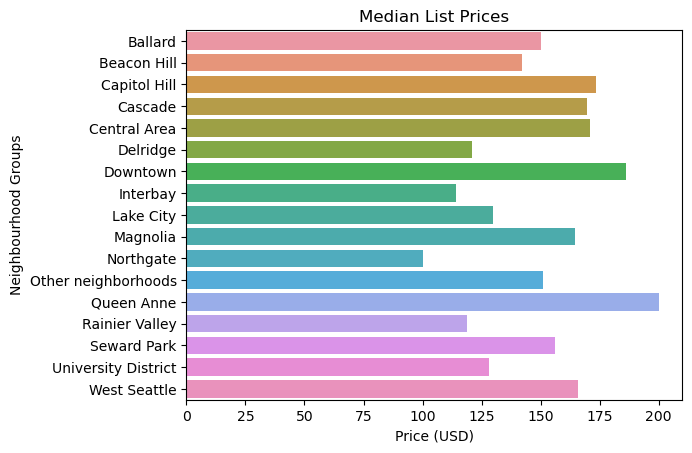

In [32]:
#obtain median values by neighborhood 
neighbourhood_group_prices = listings_df[['neighbourhood_group','price']].groupby('neighbourhood_group', as_index=False).median()

#plot in seaborn
p = sns.barplot(y= 'neighbourhood_group', x= 'price', data=neighbourhood_group_prices)
p.set(ylabel='Neighbourhood Groups', xlabel='Price (USD)', title= 'Median List Prices');